DATA PREPROCESSING

In [478]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import os
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import seaborn as sns
import numpy as np

df_total = pd.DataFrame()

#CHANGE THIS

user = 'omarlodhi'

# Define the folder containing the CSV files
folder_path = f'/Users/{user}/Downloads/forwards1/investing.com'
# folder containing exported figures 
figure_path = f'/Users/{user}/Downloads/forwards1/figures'


# Define the function that preprocesses the DataFrame
def investingdotcom_preprocess(df, df_name):
    # Convert 'Date' column to the desired format
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Remove 'df_' from the DataFrame name and use it as the new column name for 'Price'
    new_column_name = df_name[3:]  # Remove the 'df_' prefix
    
    # Rename 'Price' column to the new name based on DataFrame name
    df.rename(columns={'Price': new_column_name}, inplace=True)
    
    # Reorder the columns to only have the new column and 'Date'
    df = df[[new_column_name, 'Date']]

    return df

# Loop through each CSV file, read it, and preprocess the DataFrame
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

# Create a list of DataFrames to merge
dfs = []

# Initialize an empty dictionary to store processed DataFrames
dfs_dict = {}

# Loop through each CSV file
for csv_file in csv_files:
    df_name = os.path.splitext(csv_file)[0]  # Extract the base name (without extension)
    print(f"Processing {df_name}...")
    
    # Read the CSV file into a DataFrame
    df = pd.read_csv(os.path.join(folder_path, csv_file))
    print(f"Shape of {df_name}:", df.shape)
    
    # Process the DataFrame (assuming this function processes the DataFrame as needed)
    processed_df = investingdotcom_preprocess(df, f'df_{df_name}')
    
    processed_df['Date'] = pd.to_datetime(processed_df['Date'])

    # Store the processed DataFrame in the dictionary with a dynamic key
    dfs_dict[f'df_{df_name}'] = processed_df

    dfs.append(processed_df)


    
    # Optionally print the processed DataFrame
    print(f"Processed {df_name} DataFrame:")
    print(processed_df)



df_20yr_yield = dfs_dict['df_20yr_yield']
df_10yr_yield = dfs_dict['df_10yr_yield']
df_30yr_yield = dfs_dict['df_30yr_yield']
df_5yr_yield = dfs_dict['df_5yr_yield']
df_move_level = dfs_dict['df_move_level']
df_1yr_swap_rate = dfs_dict['df_1yr_swap_rate']
df_2yr_swap_rate = dfs_dict['df_2yr_swap_rate']
df_5yr_swap_rate = dfs_dict['df_5yr_swap_rate']
df_10yr_swap_rate = dfs_dict['df_10yr_swap_rate']
df_2yr_yield = dfs_dict['df_2yr_yield']





# Load and preprocess the term premium (FRBNY ACM) and breakeven data (FRED)
df_tp = pd.read_csv('ACM.csv')
print(df_tp.head())

# Extract relevant columns (10Y term premium and date)
df_tp = df_tp[['ACMY10', 'DATE']]
df_tp.rename(columns={'ACMY10': '10y_tp', 'DATE': 'Date'}, inplace=True)
df_tp['Date'] = pd.to_datetime(df_tp['Date'])

# Load and preprocess the BE (Breakeven) data
df_BE = pd.read_csv('5y5y.csv')
df_BE.rename(columns={'observation_date': 'Date', 'T5YIFR': 'BE'}, inplace=True)

df_BE['Date'] = pd.to_datetime(df_BE['Date'])


# Add the processed BE DataFrame to the list of DataFrames
dfs.append(df_tp)
dfs.append(df_BE)

print('KASHDF')
print(len(dfs))

df_total = dfs[0]


# Merge each subsequent DataFrame on 'Date'

for df in dfs[1:]:
    # Sort each DataFrame by the 'Date' column from earliest to latest

    # Merge with the previous DataFrame (df_total)
    df_total = pd.merge(df_total, df, on='Date', how='inner')

    # Print the shape after each merge
    print(df_total.shape)



#creating necessary variables

df_total['1y1y'] = ((1 + df_total['2yr_swap_rate'])**2 / (1 + df_total['1yr_swap_rate'])) - 1

df_total['spread'] = df_total['10yr_yield'] - df_total['2yr_yield']

df_total['move_level'] = df_total['move_level'].rolling(window=7).mean()  # 7-day rolling volatility

df_total['10y_expectations'] = df_total['10yr_yield'] - df_total['10y_tp']

df_total = df_total.dropna()

# subset dataset to past year for section 1 (fair value analysis)

start_date = '12-12-2023'
end_date = '12-12-2024'

# Filter the DataFrame to include only the date range
df_part1 = df_total[(df_total['Date'] >= start_date) & (df_total['Date'] <= end_date)]


# creating dataset for section 2 

# Step 1: Merging df_10yr_yield and df_20yr_yield
df_total_2 = df_10yr_yield.merge(df_20yr_yield, on="Date", how="inner")\
    .merge(df_30yr_yield, on="Date", how="inner")\
    .merge(df_tp, on="Date", how="inner")\
    .merge(df_move_level, on="Date", how="inner")\
    .merge(df_5yr_yield, on="Date", how='inner')\
    .merge(df_2yr_yield, on="Date", how='inner')

# creating necessary variables 

df_total_2['butterfly'] = df_total_2['20yr_yield'] - (df_total_2['10yr_yield'] + df_total_2['30yr_yield']) / 2

df_total_2['butterfly'] = df_total_2['butterfly']*100

df_total_2['10y_expectations'] = df_total_2['10yr_yield'] - df_total_2['10y_tp']

df_total_2['move_level'] = df_total_2['move_level'].rolling(window=7).mean() 

df_total_2['butterfly1'] = df_total_2['5yr_yield'] - (df_total_2['2yr_yield'] + df_total_2['10yr_yield']) / 2
df_total_2['butterfly1'] = df_total_2['butterfly1']*100
df_total_2['butterfly1_var'] = df_total_2['butterfly1'].rolling(window=7).std()

df_total_2 = df_total_2.dropna()


Processing 5yr_yield...
Shape of 5yr_yield: (4715, 6)
Processed 5yr_yield DataFrame:
      5yr_yield       Date
0         4.031 2024-12-06
1         4.074 2024-12-05
2         4.070 2024-12-04
3         4.112 2024-12-03
4         4.091 2024-12-02
...         ...        ...
4710      4.457 2006-12-12
4711      4.501 2006-12-11
4712      4.523 2006-12-08
4713      4.450 2006-12-07
4714      4.456 2006-12-06

[4715 rows x 2 columns]
Processing move_level...
Shape of move_level: (4458, 7)
Processed move_level DataFrame:
      move_level       Date
0          83.20 2024-12-06
1          91.48 2024-12-05
2          92.25 2024-12-04
3          95.60 2024-12-03
4          97.81 2024-12-02
...          ...        ...
4453       64.70 2006-12-12
4454       68.30 2006-12-11
4455       71.10 2006-12-08
4456       75.60 2006-12-07
4457       75.00 2006-12-06

[4458 rows x 2 columns]
Processing 30yr_yield...
Shape of 30yr_yield: (4645, 6)
Processed 30yr_yield DataFrame:
      30yr_yield       Date
0

/var/folders/zy/p9cjssgn4rdfy2wsbdjm_6w40000gn/T/ipykernel_66795/1855610108.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processed_df['Date'] = pd.to_datetime(processed_df['Date'])
/var/folders/zy/p9cjssgn4rdfy2wsbdjm_6w40000gn/T/ipykernel_66795/1855610108.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processed_df['Date'] = pd.to_datetime(processed_df['Date'])
/var/folders/zy/p9cjssgn4rdfy2wsbdjm_6w40000gn/T/ipykernel_66795/1855610108.py:59: SettingWithCopyWarning: 
A value is trying to be se

FIGURE 1

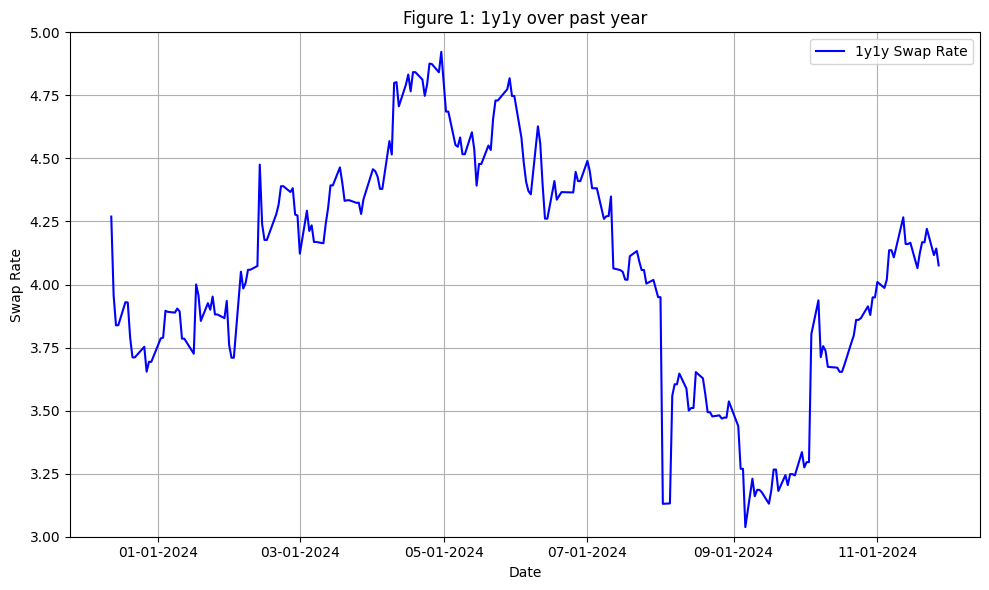

In [479]:

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd


# Plot the data
plt.figure(figsize=(10, 6))

plt.plot(df_part1['Date'], df_part1['1y1y'], label='1y1y Swap Rate', color='blue')

# Set the title and labels
plt.xlabel('Date')
plt.ylabel('Swap Rate')
plt.title('Figure 1: 1y1y over past year')
plt.legend()
plt.grid(True)

# Customize y-axis limits (example: set between 0 and 100)
plt.ylim(3, 5)  # Adjust these values as per your dataset range

# Format x-axis to show dates in MM-DD-YYYY format
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d-%Y'))


# Save the plot as a JPEG file
plt.tight_layout()

# Save the figure as a JPEG file
plt.savefig(f'{figure_path}/figure1.jpg', format='jpeg')
# Rotate the x-axis labels to avoid overlap
plt.xticks(rotation=0)

# Show the plot
plt.tight_layout()
plt.show()





FIGURE 2

Linear Regression Results:
------------------------------
Coefficients for each feature:
const: -1.4998 (SE: 0.3965)
1y1y: -0.3284 (SE: 0.0254)
BE: 1.0336 (SE: 0.1772)
move_level: 0.0023 (SE: 0.0011)

Intercept: -1.4998 (SE: 0.3965)

R-squared: 0.4822


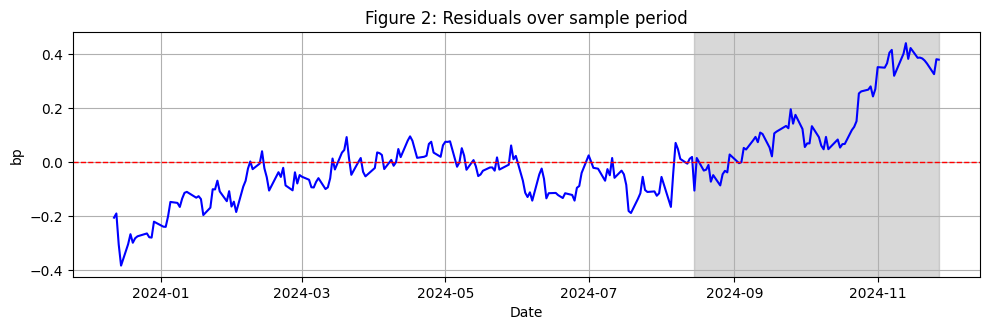

,Date,Actual,Predicted,Residuals
6,2024-11-27,0.031,-0.349261,0.380261
7,2024-11-26,0.047,-0.334897,0.381897
8,2024-11-25,0.003,-0.323584,0.326584
9,2024-11-22,0.031,-0.334834,0.365834
10,2024-11-21,0.072,-0.304916,0.376916
...,...,...,...,...
242,2023-12-18,-0.516,-0.211923,-0.304077
243,2023-12-15,-0.534,-0.150614,-0.383386
244,2023-12-14,-0.465,-0.160024,-0.304976
245,2023-12-13,-0.409,-0.218892,-0.190108


In [480]:
def perform_regression(title, data, independent_vars, dependent_var, plot_type='line'):
    """
    Performs linear regression and plots residuals over the sample period.
    
    Parameters:
    - independent_vars (list): List of column names to be used as independent variables.
    - dependent_var (str): Name of the column to be used as the dependent variable.
    - start_date (str or pd.Timestamp): The date to start the analysis from (e.g., '2024-09-01').
    - plot_type (str): Type of plot ('line') for residuals. Scatter plot option has been removed.
    
    Outputs the regression coefficients, intercept, R-squared value, standard errors, and a residuals plot.
    Returns a DataFrame containing the residuals.
    """
    df = data
    # Independent and dependent variables for regression
    X = df[independent_vars]
    y = df[dependent_var]

   
    # Add a constant to the model for the intercept term (required by statsmodels)
    X = sm.add_constant(X)
    
    # Fit the regression model using statsmodels
    model = sm.OLS(y, X).fit()

    # Regression results
    print("Linear Regression Results:")
    print("-" * 30)
    print("Coefficients for each feature:")
    for feature, coef, stderr in zip(X.columns, model.params, model.bse):
        print(f"{feature}: {coef:.4f} (SE: {stderr:.4f})")
    print(f"\nIntercept: {model.params['const']:.4f} (SE: {model.bse['const']:.4f})")
    print(f"\nR-squared: {model.rsquared:.4f}")
    
    # Get predicted values
    y_pred = model.predict(X)

    # Calculate residuals
    residuals = y - y_pred

    # Create a DataFrame containing residuals, actual values, and predicted values
    residuals_df = pd.DataFrame({
        'Date': df['Date'],
        'Actual': y,
        'Predicted': y_pred,
        'Residuals': residuals
    })

    # Plotting the residuals
    plt.figure(figsize=(10, 6))

    # Plot residuals over time (line plot only)
    plt.subplot(2, 1, 1)
    plt.plot(df['Date'], residuals, label='Residuals', color='blue')
    plt.axhline(0, color='red', linestyle='--', linewidth=1)  # Add a red dashed line at 0

    # Add light grey hue starting from start_date
    plt.axvspan('2024-08-15', '2024-11-27', color='grey', alpha=0.3)

    plt.xlabel('Date')
    plt.ylabel('bp')
    plt.title('Figure 2: Residuals over sample period')
    plt.grid(True)


    plt.savefig(f'{figure_path}/figure2.jpg', format='jpeg')

    # Display the plots
    plt.tight_layout()
    plt.show()

    # Return the residuals DataFrame
    return residuals_df

steepening_start = '2024-08-15'

perform_regression('main_regression_residuals', df_part1, ['1y1y', 'BE', 'move_level'], 'spread')


FIGURE 3

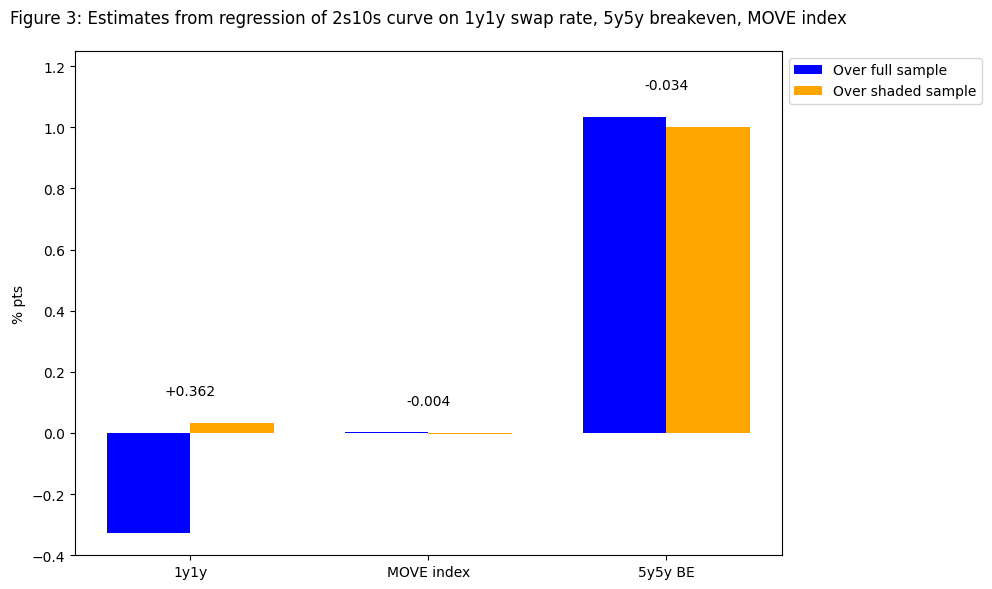

In [485]:
# Full sample regression
X_full = df_part1[['1y1y', 'move_level', 'BE']]  # Independent variables
y_full = df_part1['spread']  # Dependent variable
X_full = sm.add_constant(X_full)  # Add constant (intercept)
model_full = sm.OLS(y_full, X_full).fit()  # OLS regression
coef_full = model_full.params[['1y1y', 'move_level', 'BE']]  # Coefficients for the full sample

# Restricted sample regression (Date >= '2024-08-15')
df_restricted = df_part1[df_part1['Date'] >= steepening_start]
X_restricted = df_restricted[['1y1y', 'move_level', 'BE']]  # Independent variables
y_restricted = df_restricted['spread']  # Dependent variable
X_restricted = sm.add_constant(X_restricted)  # Add constant (intercept)
model_restricted = sm.OLS(y_restricted, X_restricted).fit()  # OLS regression
coef_restricted = model_restricted.params[['1y1y', 'move_level', 'BE']]  # Coefficients for the restricted sample

# Data for bar plot
coefficients = [coef_full, coef_restricted]
labels = ['Full Sample', 'Restricted Sample (Date >= 2024-08-26)']
colors = ['blue', 'orange']

# Create the bar plot
fig, ax = plt.subplots(figsize=(10, 6))

# Set positions for the bars
bar_width = 0.35  # Adjust width of bars
index = ['1y1y', 'MOVE index', '5y5y BE']
x_pos = [i - bar_width / 2 for i in range(len(index))]  # Positions for full sample bars
x_pos_restricted = [i + bar_width / 2 for i in range(len(index))]  # Positions for restricted sample bars

# Plot bars for each coefficient
bars_full = ax.bar(x_pos, coef_full, bar_width, color='blue', label='Over full sample')
bars_restricted = ax.bar(x_pos_restricted, coef_restricted, bar_width, color='orange', label='Over shaded sample')

# Add the numeric differences at the midpoint of the two bars in each pair
for i in range(len(index)):
    # Calculate the difference between full sample and restricted sample for each variable
    diff = coef_restricted.iloc[i] - coef_full.iloc[i]
    
    # Midpoint between the two bars
    midpoint = (x_pos[i] + x_pos_restricted[i]) / 2
    
    # Add the text (difference) at the midpoint above the bars

    if diff > 0:
       ax.text(midpoint, max(coef_full.iloc[i], coef_restricted.iloc[i]) + 0.08, f'+{diff:.3f}', ha='center', va='bottom', fontsize=10, color='black') 
    
    else:
        ax.text(midpoint, max(coef_full.iloc[i], coef_restricted.iloc[i]) + 0.08, f'{diff:.3f}', ha='center', va='bottom', fontsize=10, color='black')

# Customizing the graph
ax.set_title('Figure 3: Estimates from regression of 2s10s curve on 1y1y swap rate, 5y5y breakeven, MOVE index', pad=20)
ax.set_ylabel('% pts')
ax.set_xticks(range(len(index)))  # Set x-ticks in the center of the pairs of bars
ax.set_xticklabels(index)  # Label each pair (1y1y, move_level, BE)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.savefig(f'{figure_path}/figure3.jpg', format='jpeg')

# Set y-axis limits (adjust based on data range)
ax.set_ylim([-0.4, 1.25])  # Adjust this as needed based on the range of your coefficients

# Adjust layout to avoid clipping
plt.tight_layout()


# Display the plot
plt.show()

FIGURE 4

/var/folders/zy/p9cjssgn4rdfy2wsbdjm_6w40000gn/T/ipykernel_66795/4139516521.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_restricted = df_part1[df_total['Date'] >= '2024-08-15']


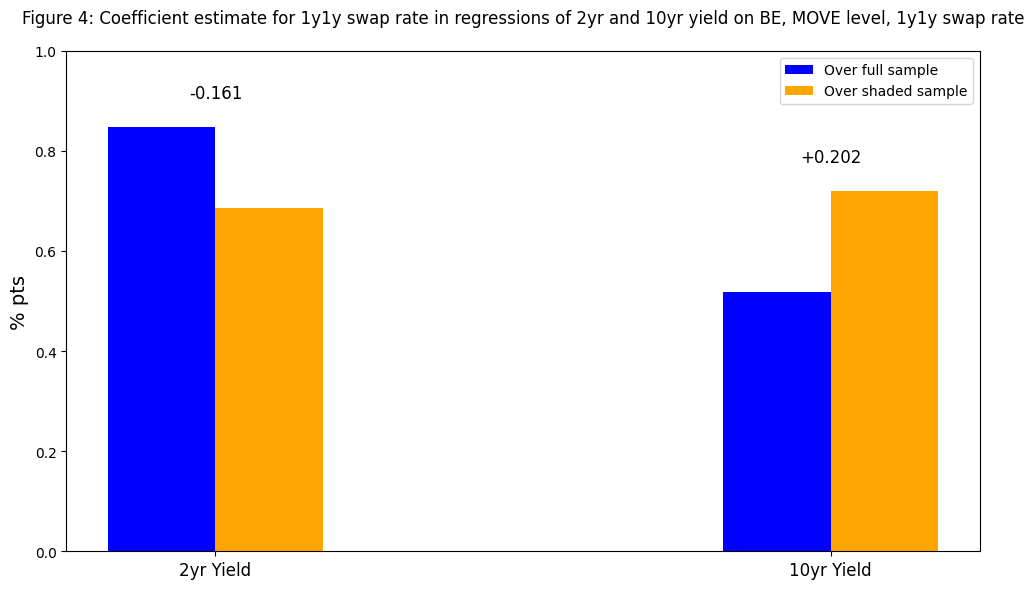

In [486]:

# Assuming df_total is already defined

# Full sample regression for 2yr_yield
X_full = df_part1[['BE', 'move_level', '1y1y']]  # Independent variables
y_full_2yr = df_part1['2yr_yield']  # Dependent variable
X_full = sm.add_constant(X_full)  # Add constant (intercept)
model_full_2yr = sm.OLS(y_full_2yr, X_full).fit()  # OLS regression
coef_full_2yr = model_full_2yr.params['1y1y']  # Coefficient for 1y1y in full sample

# Restricted sample regression for 2yr_yield (Date >= '2024-08-15')
df_restricted = df_part1[df_total['Date'] >= '2024-08-15']
X_restricted = df_restricted[['BE', 'move_level', '1y1y']]  # Independent variables
y_restricted_2yr = df_restricted['2yr_yield']  # Dependent variable
X_restricted = sm.add_constant(X_restricted)  # Add constant (intercept)
model_restricted_2yr = sm.OLS(y_restricted_2yr, X_restricted).fit()  # OLS regression
coef_restricted_2yr = model_restricted_2yr.params['1y1y']  # Coefficient for 1y1y in restricted sample

# Full sample regression for 10yr_yield
X_full_10yr = df_part1[['BE', 'move_level', '1y1y']]  # Independent variables
y_full_10yr = df_part1['10yr_yield']  # Dependent variable
X_full_10yr = sm.add_constant(X_full_10yr)  # Add constant (intercept)
model_full_10yr = sm.OLS(y_full_10yr, X_full_10yr).fit()  # OLS regression
coef_full_10yr = model_full_10yr.params['1y1y']  # Coefficient for 1y1y in full sample

# Restricted sample regression for 10yr_yield (Date >= '2024-08-15')
df_restricted_10yr = df_restricted[['BE', 'move_level', '1y1y', '10yr_yield']]
y_restricted_10yr = df_restricted_10yr['10yr_yield']  # Dependent variable
X_restricted_10yr = sm.add_constant(df_restricted_10yr[['BE', 'move_level', '1y1y']])  # Add constant (intercept)
model_restricted_10yr = sm.OLS(y_restricted_10yr, X_restricted_10yr).fit()  # OLS regression
coef_restricted_10yr = model_restricted_10yr.params['1y1y']  # Coefficient for 1y1y in restricted sample

# Data for plotting
coefficients_2yr = [coef_full_2yr, coef_restricted_2yr]
coefficients_10yr = [coef_full_10yr, coef_restricted_10yr]
labels = ['Full Sample', 'Restricted Sample (Date >= 2024-08-15)']

# Set up the bar width and positions
bar_width = 0.35
index_2yr = [0, bar_width]  # Positions for 2yr_yield bars (touching)
index_10yr = [2, 2 + bar_width]  # Positions for 10yr_yield bars (gap between 2yr and 10yr)

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars for 2yr_yield and 10yr_yield regressions
bar_2yr_full = ax.bar(index_2yr[0], coef_full_2yr, bar_width, label='Over full sample', color='blue')
bar_2yr_restricted = ax.bar(index_2yr[1], coef_restricted_2yr, bar_width, label='Over shaded sample', color='orange')

bar_10yr_full = ax.bar(index_10yr[0], coef_full_10yr, bar_width, color='blue')
bar_10yr_restricted = ax.bar(index_10yr[1], coef_restricted_10yr, bar_width, color='orange')

# Add the numeric differences on top of the midpoint of the bars
diff_2yr = coef_restricted_2yr - coef_full_2yr
diff_10yr = coef_restricted_10yr - coef_full_10yr

# Midpoint of bars for the difference text
midpoint_2yr = (index_2yr[0] + index_2yr[1]) / 2
midpoint_10yr = (index_10yr[0] + index_10yr[1]) / 2

ax.text_2yr = (index_2yr[0])

# Add the difference text
ax.text(midpoint_2yr, max(coef_full_2yr, coef_restricted_2yr) + 0.05, f'{diff_2yr:.3f}', ha='center', va='bottom', fontsize=12, color='black')
ax.text(midpoint_10yr, max(coef_full_10yr, coef_restricted_10yr) + 0.05, f'+{diff_10yr:.3f}', ha='center', va='bottom', fontsize=12, color='black')

# Customizing the graph
ax.set_title('Figure 4: Coefficient estimate for 1y1y swap rate in regressions of 2yr and 10yr yield on BE, MOVE level, 1y1y swap rate', fontsize=12, pad='20')
ax.set_ylabel('% pts', fontsize=14)

# Set the x-axis positions and labels
ax.set_xticks([np.mean(index_2yr), np.mean(index_10yr)])  # Position x-ticks in the middle of each pair
ax.set_xticklabels(['2yr Yield', '10yr Yield'], fontsize=12)

# Set y-axis limits (customize as needed)
ax.set_ylim([0, 1])  # Adjust the y-axis limits based on your data

# Add a legend
ax.legend()
plt.savefig(f'{figure_path}/figure4.jpg', format='jpeg')

# Tight layout to avoid clipping
plt.tight_layout()

# Show the plot
plt.show()

FIGURE 5 (using full sample from here onwards)

                            OLS Regression Results                            
Dep. Variable:         butterfly1_var   R-squared:                       0.244
Model:                            OLS   Adj. R-squared:                  0.244
Method:                 Least Squares   F-statistic:                     1437.
Date:                Wed, 18 Dec 2024   Prob (F-statistic):          1.20e-272
Time:                        20:34:59   Log-Likelihood:                -5437.8
No. Observations:                4442   AIC:                         1.088e+04
Df Residuals:                    4440   BIC:                         1.089e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1462      0.035      4.198      0.0

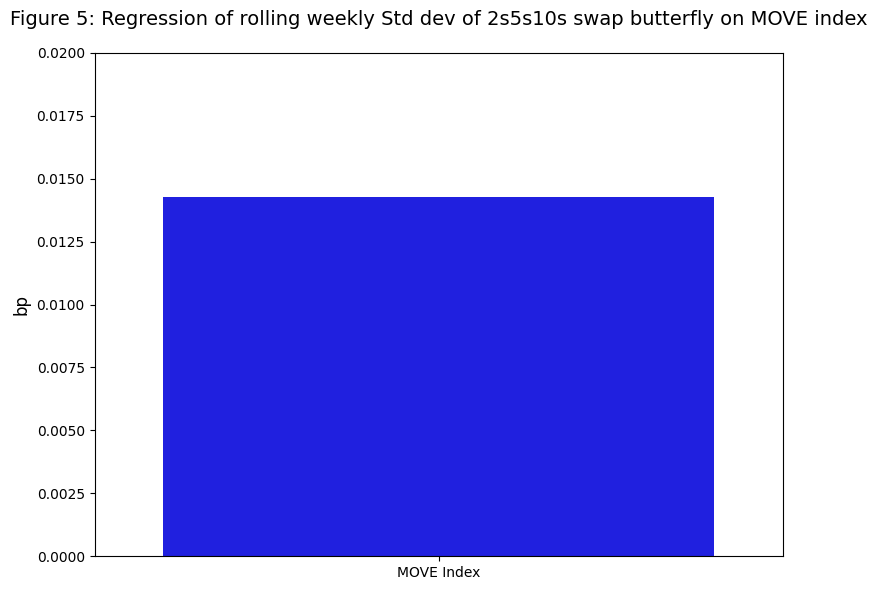

In [483]:
# Ensure 'Date' is in datetime format
df_total['Date'] = pd.to_datetime(df_total['Date'])



# Step 2: Perform OLS regression
X = df_total_2[['move_level']]  # Independent variable
y = df_total_2['butterfly1_var']  # Dependent variable

# Add a constant (intercept) to the independent variables
X = sm.add_constant(X)

# Perform the OLS regression
model = sm.OLS(y, X).fit()

# Output the regression results
print(model.summary())

# Step 3: Extract the coefficients and plot
coeffs = model.params[['move_level']]

# Create a bar plot for the coefficients
plt.figure(figsize=(8, 6))
sns.barplot(y=coeffs.values, color='blue')

# Add title and labels to the plot
plt.title('Figure 5: Regression of rolling weekly Std dev of 2s5s10s swap butterfly on MOVE index', fontsize=14, pad=20)
plt.ylabel('bp', fontsize=12)

# Optionally, set y-axis limits
plt.ylim(0, 0.02)  # Adjust this based on your coefficient values

# Customizing x-axis labels
plt.xticks(ticks=[0], labels=['MOVE Index'])  # Replace 'None' with a custom label
plt.savefig(f'{figure_path}/figure5.jpg', format='jpeg')

# Show the plot
plt.tight_layout()
plt.show()


FIGURE 6

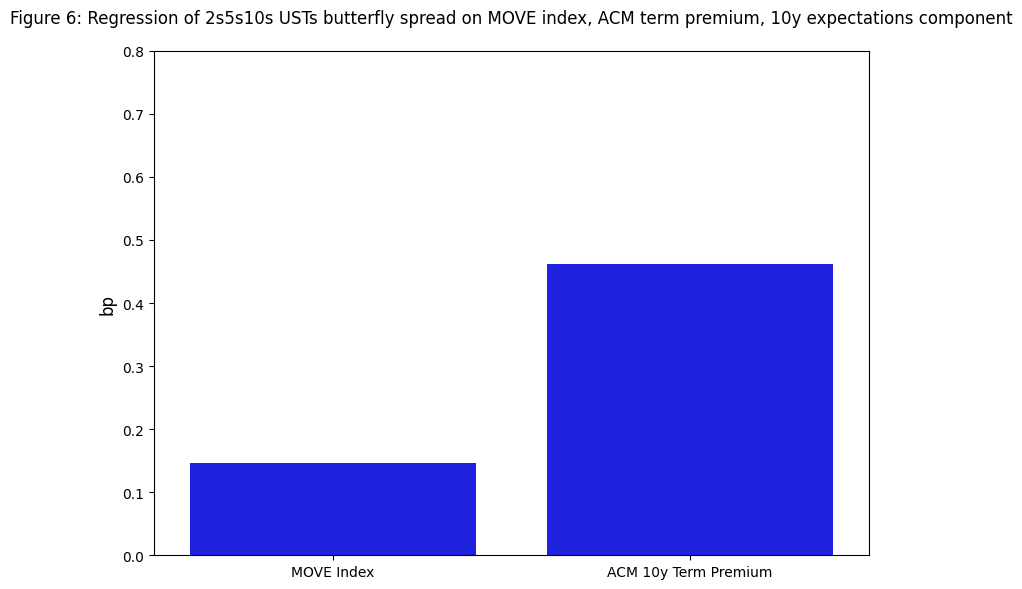

In [484]:


# Define independent and dependent variables for the regression
X = df_total_2[['move_level', '10y_tp', '10y_expectations']]  # Independent variables
y = df_total_2['butterfly']  # Dependent variable

# Add a constant (intercept) to the independent variables
X = sm.add_constant(X)

# Perform the OLS regression
model = sm.OLS(y, X).fit()

custom_labels = {
    'move_level': 'MOVE Index',
    '10y_tp': 'ACM 10y Term Premium'
}
# Extract the coefficients
coeffs = model.params[['move_level', '10y_tp']]

# Create a bar plot for the coefficients with custom labels
plt.figure(figsize=(8, 6))
sns.barplot(x=[custom_labels.get(label, label) for label in coeffs.index], y=coeffs.values, color='blue')


# Add titles and labels
plt.title('Figure 6: Regression of 2s5s10s USTs butterfly spread on MOVE index, ACM term premium, 10y expectations component', fontsize=12, pad=20)
plt.ylabel('bp', fontsize=12)

# Option 1: Manually set the y-axis limits
plt.ylim(0, 0.8)  # Set y-axis limits between -0.5 and 0.5


plt.savefig(f'{figure_path}/figure6.jpg', format='jpeg')

# Show the plot
plt.tight_layout()
plt.show()